In [1]:
#UPDATED FOR PYTORCH 0.4
#https://pytorch.org/2018/04/22/0_4_0-migration-guide.html


#https://www.sanyamkapoor.com/machine-learning/pytorch-data-loaders/
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.utils.data as utils_data
from torch import optim, nn
from torch.utils.data import Dataset, DataLoader 
import torch.nn.functional as F
from torch.nn.init import xavier_normal_, xavier_uniform_
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error

cuda=True #set to true uses GPU




<h2>First Start with just looking at custom data loader</h2>

In [2]:

#here is just basic example of custom dataloader https://www.youtube.com/watch?v=zN49HdDxHi8&index=8&list=PLlMkM4tgfjnJ3I-dbhO9JTw7gNty6o_2m
class testLoader(Dataset):
      def __init__(self):
            
            #regular old numpy
            boston = load_boston()
            x=boston.data
            y=boston.target
            y=y.reshape(y.shape[0],1)
            
            self.x = torch.from_numpy(x)
            self.y = torch.from_numpy(y)
            
            
            self.length = x.shape[0]
            self.vars =x.shape[1]
          
      def __getitem__(self, index):

          return self.x[index], self.y[index]

      def __len__(self):
          return self.length



Net(
  (fc1): Linear(in_features=13, out_features=20, bias=True)
  (drop): Dropout(p=0.5)
  (fc2): Linear(in_features=20, out_features=1, bias=True)
)


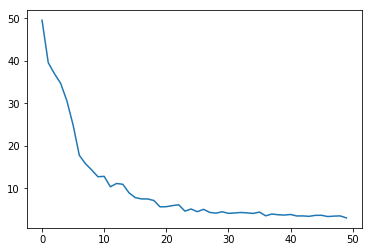

In [3]:
#everything the same as other notebook
training_samples=testLoader()
train_loader = DataLoader(training_samples, batch_size=64, shuffle=True)

#define the MLP


#override this
class Net(nn.Module):
    def __init__(self):
         super(Net, self).__init__()
         
         #all the layers
         self.fc1   = nn.Linear(training_samples.vars, 20)
         xavier_uniform_(self.fc1.weight.data) #this is how you can change the weight init
         self.drop = nn.Dropout(p=0.5)
         self.fc2   = nn.Linear(20, 1)
         
    #    
    def forward(self, x):
            x = F.relu(self.fc1(x))
            x=  self.drop(x)
            x = self.fc2(x)
            
            return x
        
        
net=Net()
if cuda:
    net.cuda()
print(net)

# create a stochastic gradient descent optimizer
optimizer = optim.Adam(net.parameters())
# create a loss function (mse)
loss = nn.MSELoss(size_average=True)

# run the main training loop
epochs =50
hold_loss=[]

for epoch in range(epochs):
    cum_loss=0.
    for batch_idx, (data, target) in enumerate(train_loader):
        tr_x, tr_y = data.float(), target.float()
        
        if cuda:
            tr_x, tr_y = tr_x.cuda(), tr_y.cuda() 
            
        # Reset gradient
        optimizer.zero_grad()

        # Forward pass
        fx = net(tr_x)
        output = loss(fx, tr_y) #loss for this batch
        cum_loss += output.item() #accumulate the loss
        
        # Backward 
        output.backward()
        
        # Update parameters based on backprop
        optimizer.step()
    hold_loss.append(cum_loss/len(training_samples))    
    #print(epoch+1, cum_loss) #
plt.plot(np.array(hold_loss))

<h2>Now look at example again ...this one from https://www.sanyamkapoor.com/machine-learning/pytorch-data-loaders/<h2>

In [2]:
class MyDataset(Dataset):
    """
    This dataset contains a list of numbers in the range [a,b] inclusive
    """
    def __init__(self, a=0, b=1):
        super(MyDataset, self).__init__()
        
        assert a <= b
        
        self.a = a
        self.b = b
        
    def __len__(self):
        return self.b - self.a + 1
        
    def __getitem__(self, index):
        print(index)
        #assert self.a <= index <= self.b
        
        return (index, index**2)

In [6]:

#we create a dataset with 10 numbers 
data_train = MyDataset(a=1,b=10)
data_train_loader = DataLoader(data_train, batch_size=8, shuffle=False) #change to True to see that the order of index changes each time
print(len(data_train)) # 10

10


In [7]:
for batch_idx, (data, target) in enumerate(data_train_loader):
    pass
    print(batch_idx)
    #print(target)

0
1
2
3
4
5
6
7
0
8
9
1


<h2>Now look finally at generator when data doesnt fit in memory</h2>

In [2]:
boston = load_boston()
x=pd.DataFrame(boston.data)
x['13']=boston.target
print(x.shape)
x.to_csv('/media/jma/DATA/boston_combined.csv',index=False)

(506, 14)


In [3]:
#this is a generator to read the bostom data 
import csv 
import numpy as np 

def generate_arrays_from_file(file_name,batchsz):
    
    batchCount = 0
    
    inputs = []
    targets = []
            
    linecounter=0 #which line the reader is reading
                
    while True: #infinite loop
        with open(file_name, "r") as csvfile: 
            for line in csv.reader(csvfile):  
                
                if linecounter >0: #is not the header
                    
                    #could process data here, doing anything else (like shuffle them)
                    inputs.append(line[0:13]) #columns 1-13
                    targets.append(line[13]) #column 13

                    batchCount += 1 # we added a line

                    if batchCount >= batchsz: # we have our mini batch
                        batchCount = 0 #reset batch counter
                        
                        #X and y numpy arrays
                        X = np.array(inputs,dtype="float32")
                        y = np.array(targets,dtype="float32")
                        y=y.reshape(y.shape[0],1)
                        
                        yield (X, y)

                        #reset the lists to hold the batches
                        inputs = [] 
                        targets = []

                linecounter += 1 #increment the line read
            linecounter = 0 #reset line counter and start over reading file


In [4]:
batch_size=64
training_gen=generate_arrays_from_file('/media/jma/DATA/boston_combined.csv',batch_size)

Net(
  (fc1): Linear(in_features=13, out_features=20, bias=True)
  (drop): Dropout(p=0.5)
  (fc2): Linear(in_features=20, out_features=1, bias=True)
)


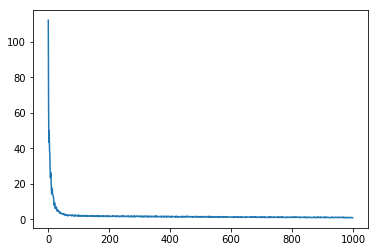

In [5]:
#each iteration should pull input data that is (64,13) and y that is (64,1)
#we need t know in advance there are 506 records in the file so 506//64 = 8
#when we run through 8 mini btches we have exhausted out training data (plus)

record_len = 506
cols=13
epoch_cntr =0
epoch_max=1000
cum_loss=0.
hold_loss=[]  

#override nn Module
class Net(nn.Module):
    def __init__(self):
         super(Net, self).__init__()
         
         #all the layers
         self.fc1   = nn.Linear(cols, 20)
         xavier_uniform_(self.fc1.weight.data) #this is how you can change the weight init
         self.drop = nn.Dropout(p=0.5)
         self.fc2   = nn.Linear(20, 1)
         
    #    
    def forward(self, x):
            x = F.relu(self.fc1(x))
            x=  self.drop(x)
            x = self.fc2(x)
            
            return x
        
        
net=Net()
if cuda:
    net.cuda()
print(net)

# create a stochastic gradient descent optimizer
optimizer = optim.Adam(net.parameters())
# create a loss function (mse)
loss = nn.MSELoss(size_average=True)

for batch_indx,(X,y) in enumerate(training_gen):

    #train model here, do valudation etc
    tr_x, tr_y = torch.from_numpy(X).float(), torch.from_numpy(y).float()
    
    if cuda:
        tr_x, tr_y = tr_x.cuda(), tr_y.cuda() 
            
    # Reset gradient
    optimizer.zero_grad()

    # Forward pass
    fx = net(tr_x)
    output = loss(fx, tr_y) #loss for this batch
    cum_loss += output.item() #accumulate the loss
        
    # Backward 
    output.backward()
        
    # Update parameters based on backprop
    optimizer.step()
       
 
    
    
    
    if (batch_indx >0) & (batch_indx % (record_len //batch_size) ==0): #we went through all the data
            epoch_cntr +=1
            hold_loss.append(cum_loss/record_len)
            cum_loss=0. #reset
    
       
    #DONE!
    if epoch_cntr >= epoch_max:
        break
        
plt.plot(np.array(hold_loss))
    

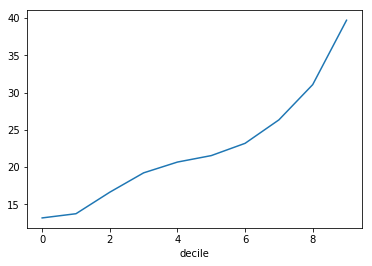

In [16]:
#see how looks on training data
#cheat and now hold in memory
import pandas as pd

boston = load_boston()

x=boston.data
y=boston.target
tr_x, tr_y = torch.from_numpy(x).float().cuda(), torch.from_numpy(y).float()

net.eval() #MUST DO THIS TO TURN OFF DROPOFF BEHAVIOR (opposite is model.train())

preds= net(tr_x)
preds=preds.cpu().data.numpy()
preds=pd.DataFrame(preds,columns=['score'])
preds['y']=y
preds['decile']=pd.qcut(preds.score,10,labels=False)
preds.groupby('decile')['y'].mean().plot()

In [17]:
preds.head()

,score,y,decile
0,30.368252,24.0,9
1,23.258600,21.6,6
2,29.218382,34.7,8
3,29.338285,33.4,8
4,26.821287,36.2,8
